### ПРОЕКТ: ПРОГНОЗИРОВАНИЕ ЗАГРУЗКИ ТАКСИ

Ввдение: 
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Описание: 
Необходимо постройть модель для предсказания числа заказов с точностью до часа. 
Имеются данные по числу заказов за час за 6 месяцев.
Других данных нет.
Модель должна иметь метрику RMSE на тестовой выборке не больше 48

Структура:
- Загрузка данных
- Изучение данных и предварительный анализ
- Подготовка данных для построения моделей (деление выборки, подготовка признаков)
- Построение двух моделей с подбором параметров
- Проверка лучших моделей на тестовых данных


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
import sys
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA 



In [2]:
try:
    df_full = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
   
    # Серверный путь
    
except:
    df_full = pd.read_csv('G:\Мой диск\MY\Образование\Data Sience\Проекты\Проект 12 Такси прогноз/taxi.csv', 
                     index_col=[0], parse_dates=[0])
        
      # Локальный путь


In [3]:
#ресемплирование данных 

df_full.sort_index(inplace=True)
df = df_full.resample('1H').sum()

In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<AxesSubplot:xlabel='datetime'>

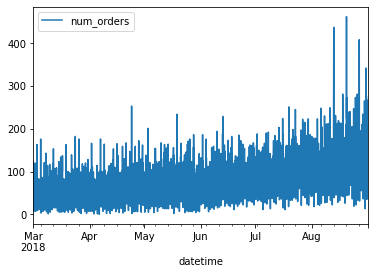

In [5]:
df.plot()

#график за весь период

In [6]:
#Декомпозиция сезонности

decomposed = seasonal_decompose(df)

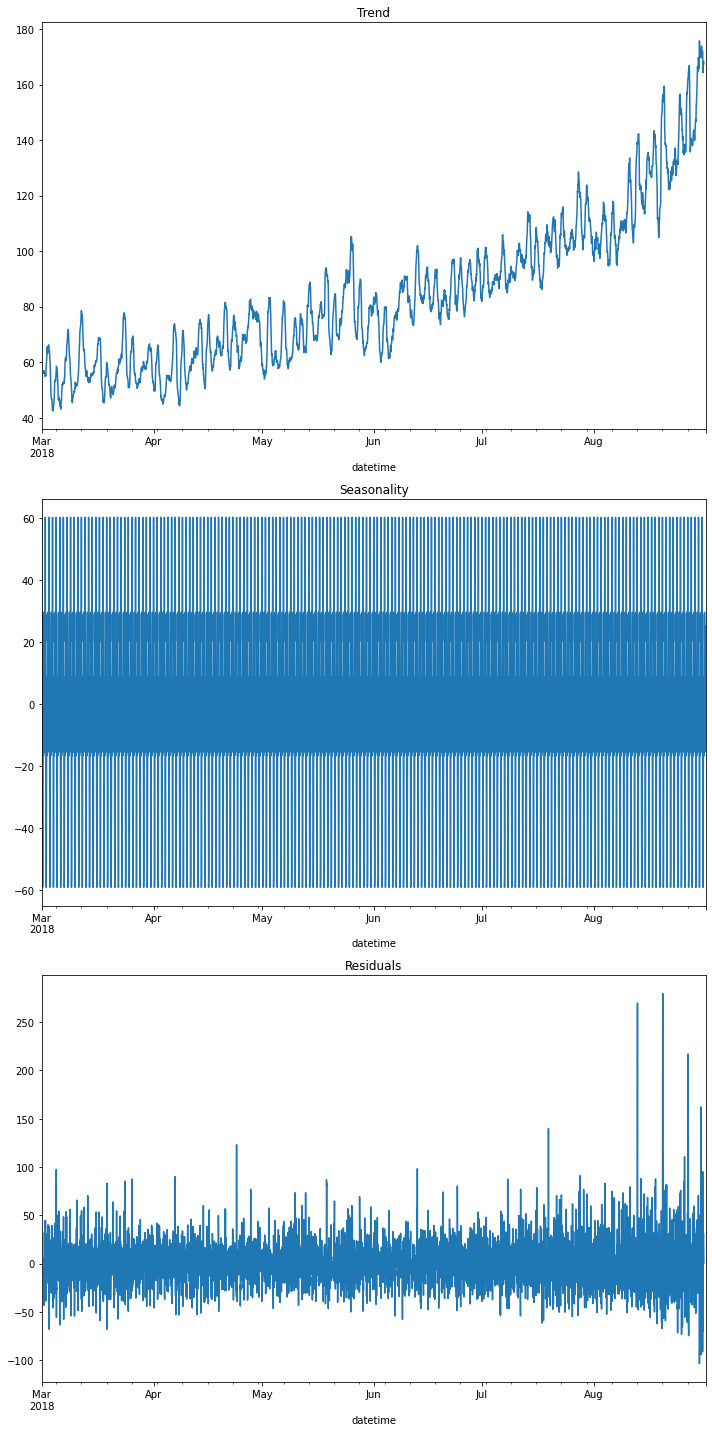

In [7]:
plt.figure(figsize=(10, 20))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')


plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Text(0.5, 1.0, 'Seasonality')

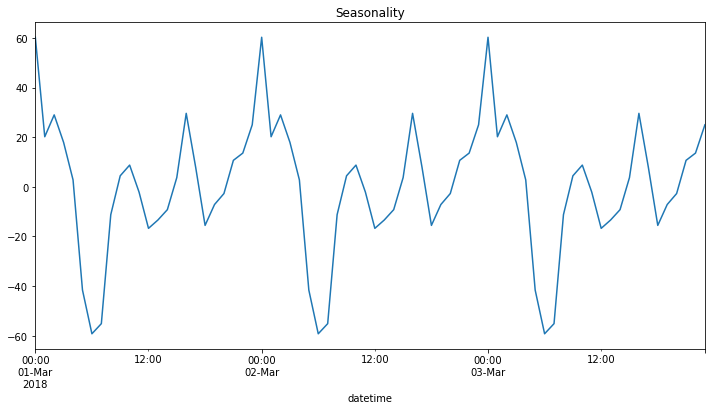

In [8]:
plt.figure(figsize=(12, 6))
decomposed.seasonal['2018-03-01' : '2018-03-03'].plot(ax=plt.gca()) 
plt.title('Seasonality')

In [9]:
df_week = df_full.resample('1D').sum()
df_week.head()

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259


In [10]:
decomposed_w = seasonal_decompose(df_week)


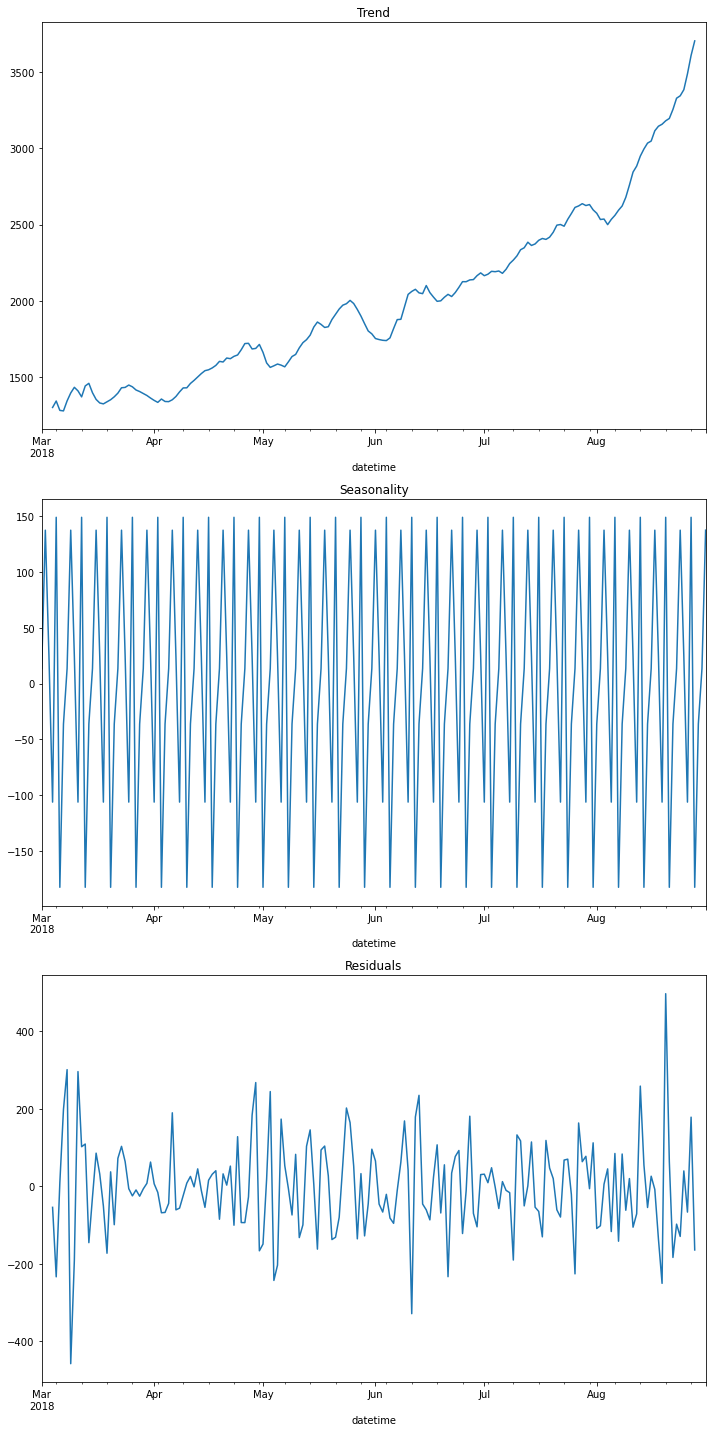

In [11]:
plt.figure(figsize=(10, 20))
plt.subplot(311)
decomposed_w.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed_w.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')

plt.subplot(313)
decomposed_w.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Text(0.5, 1.0, 'Seasonality')

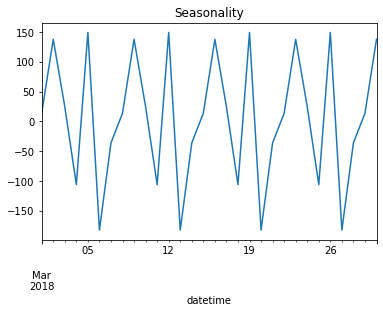

In [12]:
decomposed_w.seasonal['2018-03-01' : '2018-03-30'].plot(ax=plt.gca()) 
plt.title('Seasonality')

### ВЫВОД 2

Видны следующие закономерности:
- Восходящий тренд заказов за весь период
- Внутридневную сезонность: минимум в 6 утра, максимумы в 18 и 24 часа
- Внутримесячную сезонность: минимумы по вторникам

<AxesSubplot:xlabel='datetime'>

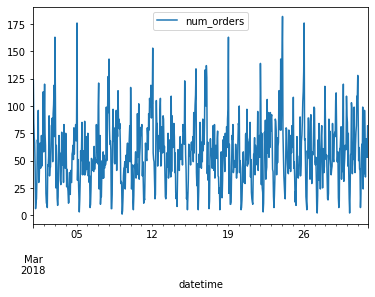

In [13]:
df_march = df['2018-03-01':'2018-03-31']
df_march.plot()

#график за месяц

<AxesSubplot:xlabel='datetime'>

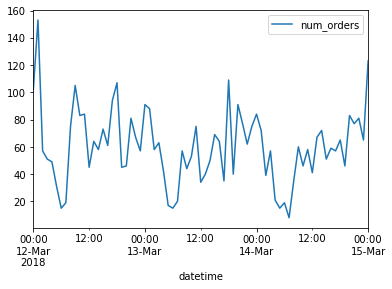

In [14]:
df_2 = df['2018-03-12 00:00:00':'2018-03-15 00:00:00']
df_2.plot()
#график за три дня

In [15]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


#### Первый этап

Данные загружены
Произведено ресеплирование по одному часу
Получены описательные характеристики

Мы видимчто основновное число заказов находится в диапазоне от 54 до 107 заказов в час  
Среднее 84, медиана 78.  
Минимальное значение 0, максимальное 462  
Данные за период март - август 2018 года  
В целом мы наблюдаем восходящий тренд заказов с сильными колебаниями  

Графики с разной точностью изображения позволяют предположить, что колебания в первую очередь носят внутри дневной характер: стабильный минимум в 6 часов.  
Пики немного разнятся по времени: возможно самолеты прилетают не ежедневно (например из одних городов в одни дни, а в другие из других).  


In [1]:
#создаем переменные часа и дня недели для удобства

def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data = data.dropna()
    return data


In [17]:
df_full = make_features(df, 168, 24)

print('rolling_mean=', df_full['rolling_mean'])

rolling_mean= datetime
2018-03-08 00:00:00     60.041667
2018-03-08 01:00:00     61.833333
2018-03-08 02:00:00     60.041667
2018-03-08 03:00:00     61.750000
2018-03-08 04:00:00     61.833333
                          ...    
2018-08-31 19:00:00    164.875000
2018-08-31 20:00:00    167.541667
2018-08-31 21:00:00    168.041667
2018-08-31 22:00:00    166.416667
2018-08-31 23:00:00    169.125000
Freq: H, Name: rolling_mean, Length: 4248, dtype: float64


C:\Users\OLEG\AppData\Local\Temp/ipykernel_17096/2176461809.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
C:\Users\OLEG\AppData\Local\Temp/ipykernel_17096/2176461809.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


In [18]:
#развибиваем выборку на тренировочную, валидационную и тестовую

test_all, test = train_test_split(df_full, shuffle=False, test_size=0.1)
train, valid = train_test_split(test_all, shuffle=False, test_size=0.1)

train_X = train.drop('num_orders', axis=1)
valid_X = valid.drop('num_orders', axis=1)
test_X = test.drop('num_orders', axis=1)
train_y = train['num_orders']
valid_y = valid['num_orders']
test_y = test['num_orders'] 


In [19]:
#строю модель линейной регрессии

model = LinearRegression() # < обучите модель >
model.fit(train_X, train_y) # < напишите код здесь >
pred_train = model.predict(train_X)
pred_valid = model.predict(valid_X)

print("RMSE обучающей выборки:", sqrt(mean_squared_error(train_y, pred_train)))
print("RMSE валидационной выборки: ", sqrt(mean_squared_error(valid_y, pred_valid)))

RMSE обучающей выборки: 19.436113437253425
RMSE валидационной выборки:  29.03224748695921


#### Построена модель

Линейной регрессии и получены хорошие показатели RMSE на входных данных
Проверяю ее качество на ВАЛИДАЦИОННОЙ выборке
Критерий успеха 48 или меньше (в скобках параметры число лагов и сглаживание)

Первая попытка: 43.3 (6, 6)

Вторая попытка: 34 (24, 48) - видно что суточные циклы и усреднение на 2 дня дают лучший прогноз

Третья попытка 29.5 (96, 48) - достигнута нужная точность за счет использования лагов до 4 дней и сглаживания на 2 суток

Четвертая попытка 29.5 (96, 24)

Пятая попытка 34.4 (24, 24) - Данная модель представляется наиболее адекватной. Она учитывает и внутри суточные колебания (24 лага по 1 часу) и сглаживание за сутки (например, фактор погоды, когда люди в плохую погоду чаще используют такси)

Шестая попытка 29.4 (120, 24) - результат лучше, возможно за счет учета не ежедневных рейсов

Седьмая попытка 29.0 (168, 24) - рассматриваю ежеделельные лаги по часу (как фактор недельного расписания рейсов). Результат немного лучше, но коэффициенты лага и скользящего среднего снова приобретают огромные значения, что подозрительно. 



In [2]:
#перебор комбинаций лагов и сглаживания

lag = [16,24,48,96,192]
smooth = [16,24,48,168,336]


for l in lag:
    for sm in smooth:
        df_f = make_features(df, l, sm)
        
        test_all, test = train_test_split(df_f, shuffle=False, test_size=0.1)
        train, valid = train_test_split(test_all, shuffle=False, test_size=0.1)

        train_X = train.drop('num_orders', axis=1)
        valid_X = valid.drop('num_orders', axis=1)
        test_X = test.drop('num_orders', axis=1)
        train_y = train['num_orders']
        valid_y = valid['num_orders']
        test_y = test['num_orders'] 

        
        model = LinearRegression() 
        model.fit(train_X, train_y) 
        pred_train = model.predict(train_X)
        pred_valid = model.predict(valid_X)
        
        
        #lasso = Lasso(normalize=True)
        #lasso.fit(train_X, train_y)
        #lasso_pred = lasso.predict(valid_X)
        print("Лаг:",l, "  Сглаживание:", sm, " RMSE валидационной выборки: ", 
              sqrt(mean_squared_error(valid_y, pred_valid)))

NameError: name 'df' is not defined

In [3]:
#пробую другой метод прогнозирования

from sklearn.tree import DecisionTreeRegressor

for depth in range(1, 50):
    
    model_DTR_roughter = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model_DTR_roughter.fit(train_X, train_y)
    
    pred_valid = model_DTR_roughter.predict(valid_X)
    
    print("Глубина:", depth, " RMSE валидационной выборки: ", sqrt(mean_squared_error(valid_y, pred_valid)))

C:\Users\OLEG\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


NameError: name 'train_X' is not defined

### ВЫВОД 3

Для модели линейной регрессии лучшими на валидационной выборке является модель с лагами 192 часа (8 суток) и сглаживанием в 16 - 168 часов (16 часов - 7 суток). Показатель RMSE - 28.85.

Лучшая модель  DecisionTreeRegressor c глубиной 5 имеет показатель RMSE - 33.2.   

In [28]:
df_f = make_features(df, 192, 168)

test_all, test = train_test_split(df_f, shuffle=False, test_size=0.1)
train, valid = train_test_split(test_all, shuffle=False, test_size=0.1)

train_X = train.drop('num_orders', axis=1)
valid_X = valid.drop('num_orders', axis=1)
test_X = test.drop('num_orders', axis=1)
train_y = train['num_orders']
valid_y = valid['num_orders']
test_y = test['num_orders'] 


pred_test = model.predict(test_X)


print("RMSE тестовой выборки: ", sqrt(mean_squared_error(test_y, pred_test))) 

RMSE тестовой выборки:  34.10453848952017


# ВЫВОД 2\3

Модель линейной регрессии с параметрами недельных лагов и суточного сглаживания обеспечивает  RMSE тестовой выборки:  34.1 

Вывод 3: Улучшено на 0,4 по сравнению с предыдущим результатом.

Т.е. требование задачи выполнено. 

In [29]:
koef = pd.DataFrame({'name': list(train_X), 'b_coef': model.coef_})

print('Коэффициент b0', model.intercept_)

pd.options.display.max_rows = 180
print('Коэффициент b1-bN',koef)

Коэффициент b0 -1.123173978604953
Коэффициент b1-bN           name    b_coef
0         hour -0.094103
1    dayofweek  0.451298
2        lag_1  0.062368
3        lag_2  0.076011
4        lag_3  0.035326
..         ...       ...
190    lag_188  0.009311
191    lag_189 -0.003190
192    lag_190 -0.009916
193    lag_191 -0.067952
194    lag_192 -0.007159

[195 rows x 2 columns]


### ВЫВОДЫ ПРОЕКТА 

Построена модель обеспечивающая качество предсказания в рамках заданных параметров.

В ходе работы рассматривались модели линейной регрессии для различных лагов и параметров сглаживания. А также модель DecisionTreeRegressor с перебором глубины дерева от 1 до 50. 

Выбрана модель линейной регрессии с параметрами лага 192 часа (8 суток) и сглаживанием 168 (7 суток).
На тестовой выборке обеспечено RMSE тестовой выборки: 34.1, что ниже заданной величины 48.
